## Plan
1. Rewrite in keras - we already bucketing sequences
2. Use an embedding layer to get drug code vectors.
3. Get drug code tree thingy.
4. Use rolling diagnosis to improve model

In [1]:
#%%time
#lets use the drug code
import marshal, gzip
pt_by_len = marshal.load(open('train_comprehensive_ptbylen.m', 'rb'))
pred_by_len = marshal.load(open('pred_comprehensive_pts.m', 'rb'))

def get_maxes():
    hidden_max = [-1000.0] * 5
    input_max = [-1000.0] * 12
    for b in pt_by_len:
        for hidden, inp, label in pt_by_len[b]:
            for i, v in enumerate(hidden):
                hidden_max[i] = max(hidden_max[i], v)
            for inp_i in inp:
                for i, v in enumerate(inp_i):
                    input_max[i] = max(input_max[i], v)
    print hidden_max
    print input_max
hidden_max = [1.0, 1.0, 1.0, 1.0, 2526]
input_max = [0.997, 1.0, 4039, 6880.7, 1041874.5, 11682.85, 1, 6, 60258, 3182, 2869, 12] #must add 1!!!


In [2]:
import random
from sklearn.model_selection import train_test_split
import numpy as np

random.seed(42)
np.random.seed(42)

def shuffle(length_arr):
    train_pt_by_len = {}
    test_pt_by_len = {}
    for length in length_arr:
        if len(length_arr[length]) >= 50:
            train_pt_by_len[length], test_pt_by_len[length] = train_test_split(pt_by_len[length], test_size=0.1, random_state=42)
    
    return train_pt_by_len, test_pt_by_len

train_pt_by_len, test_pt_by_len = shuffle(pt_by_len)
bucketlengths = {}
total = 0
for b in train_pt_by_len:
    bucketlengths[len(train_pt_by_len[b][0][1])] = len(train_pt_by_len[b])
    total += len(train_pt_by_len[b])  

def prepare_input(batch):
    batch = zip(*batch)
    
    hidden = np.array(batch[0])
    hidden = np.delete(hidden, (1,2,4),1) # something sex sex age code
    hidden[:,1][hidden[:,1] == 1.0] = 0.5577 
    
    inp = np.array([l[1:] for l in batch[1]])
    inp = np.delete(inp ,range(2,9), 2) # now with post code
    
    
    labels = np.array(batch[2])
    return hidden, inp, labels
    

def random_batch(batch_size=1):
    chunk_len = np.random.choice(bucketlengths.keys(), 1, p=np.array(bucketlengths.values())/float(sum(bucketlengths.values())))[0]
    bucket = np.array(train_pt_by_len[chunk_len])    
    hidden, inp, labels = prepare_input(bucket[np.random.choice(bucket.shape[0], batch_size)])
    
    return hidden, inp, labels

test_bucketlengths = {}
test_total = 0
for b in test_pt_by_len:
    test_bucketlengths[len(test_pt_by_len[b][0][1])] = len(test_pt_by_len[b])
    test_total += len(test_pt_by_len[b])

def random_test_batch(batch_size=1):
    chunk_len = np.random.choice(test_bucketlengths.keys(), 1, p=np.array(test_bucketlengths.values())/float(sum(test_bucketlengths.values())))[0]
    bucket = np.array(test_pt_by_len[chunk_len])    
    hidden, inp, labels = prepare_input(bucket[np.random.choice(bucket.shape[0], batch_size)])
    
    return hidden, inp, labels

print total, test_total

245794 27453


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
import numpy as np
from sklearn.metrics import roc_auc_score
import os

def torchify_batch(hidden, inp, target=None):
    drugs = inp[:, :, -2]
    dxs = inp[:, :, -1]
    posts = inp[:,:,-3]
    inp = inp[:, :, :-3]
    hidden = np.repeat(hidden[:,np.newaxis, :], repeats=inp.shape[1], axis=1)
    
    inp = Variable(torch.from_numpy(inp), requires_grad=False)
    posts = Variable(torch.from_numpy(posts), requires_grad=False).long()
    drugs = Variable(torch.from_numpy(drugs), requires_grad=False).long()
    dxs = Variable(torch.from_numpy(dxs), requires_grad=False).long()
    hidden = Variable(torch.from_numpy(hidden), requires_grad=False)
    if target is not None:
        target = Variable(torch.from_numpy(target), requires_grad=False).long()
    
    return hidden, inp, posts, drugs, dxs, target

def train(chkpoint, epochs, model, criterion, optimizer, train_losses, test_losses, test_aucs, cur_epoch=0, **kwargs):
    total = 245794
    for epoch in xrange(cur_epoch+1, epochs+1):
        print('---Epoch {}---'.format(epoch))
        num_cycles = total / 40
        num_cycles /= 2
        for cycle in tqdm_notebook(xrange(num_cycles)):
            hidden, inp, target = random_batch(10)
            hidden, inp, posts, drugs, dxs, target = torchify_batch(hidden, inp, target)
            target.cuda()
            optimizer.zero_grad()
            out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda())
            loss = criterion(out, target.cuda())
            loss.backward()
            optimizer.step()
        loss_var = loss.data.cpu().numpy()[0]

        total_test_auc = 0
        total_test_loss = 0

        
        batch_aucs = []
        bootstrap = [validate(model) for _ in range(10)]
        aucs = np.array([x[1] for x in bootstrap])
        tests = np.array([x[0] for x in bootstrap])
        all_test_loss, all_test_auc = validate_all(model)

        #test_loss = total_test_loss/100.0
        test_loss, test_loss_std = np.mean(tests), np.std(tests)
        test_auc, test_auc_std = np.mean(aucs), np.std(aucs)

        train_losses.append(loss_var)
        test_losses.append(all_test_loss)
        test_aucs.append(all_test_auc)
        
        if not os.path.exists(chkpoint[:-4]):
            os.mkdir(chkpoint[:-4])

        torch.save({
                'cur_epoch': epoch,
                'train_losses': train_losses,
                'test_losses': test_losses,
                'model': model,
                'criterion': criterion,
                'optimizer': optimizer,
                'test_aucs': test_aucs,
            }, '{}/epoch-{}-{}.tar'.format(chkpoint[:-4], epoch, int(all_test_auc * 1000)))
        
        

        print('Train Loss: {}'.format(loss_var)) # pass arguments to affect saving / resume behaviour
        print('Test Loss: {} Std: {}'.format(test_loss, test_loss_std))
        print('Test AUC: {} Std: {}'.format(test_auc, test_auc_std))
        print('All Test Loss: {} AUC: {}'.format(all_test_loss, all_test_auc))
        

def validate_all(model):
    all_true = np.zeros((test_total, 2))
    all_pred = np.zeros((test_total, 2))
    total_test_loss = 0
    i = 0
    for b in test_pt_by_len:
        hidden, inp, target = prepare_input(np.array(test_pt_by_len[b]))
        target2 = target[:]
        hidden, inp, posts, drugs, dxs, target = torchify_batch(hidden, inp, target)
        out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda())

        target.cuda()

        loss = criterion(out, target.cuda())
        out_np = out.data.cpu().numpy()
        for j in xrange(target2.shape[0]):
            all_true[i, int(target2[j])] = 1
            all_pred[i] = out_np[j]
            i += 1
        total_test_loss += loss.data.cpu().numpy()[0]
    test_loss = total_test_loss/288
    test_auc = roc_auc_score(all_true, all_pred)
    return test_loss, test_auc

def validate(model):
    total_test_loss = 0
    all_true = np.zeros((4000, 2))
    all_pred = np.zeros((4000, 2))
    for i in xrange(100):
        hidden, inp, target = random_test_batch(40)
        target2 = target[:]
        hidden, inp, posts, drugs, dxs, target = torchify_batch(hidden, inp, target)
        out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda())

        target.cuda()

        loss = criterion(out, target.cuda())
        out_np = out.data.cpu().numpy()
        for j in xrange(40):
            all_true[i*40 + j, int(target2[j])] = 1
            all_pred[i*40+j] = out_np[j]
        total_test_loss += loss.data.cpu().numpy()[0]

    test_loss = total_test_loss/100.0
    test_auc = roc_auc_score(all_true, all_pred)
    return test_loss, test_auc
    

def generate_predictions_csv(model, filename):
    predictions = []
    for b in tqdm_notebook(pred_by_len):
        hidden, inp, pt_id = prepare_input(pred_by_len[b])
        hidden, inp, posts, drugs, dxs, _ = torchify_batch(hidden, inp)
        out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda()).data.cpu().numpy()
        predictions.extend(zip(pt_id, out[:,1]))

    predictions.sort()
    with open(filename, 'w') as f:
        f.write('Patient_ID,Diabetes\n')
        for a, b in predictions:
            f.write('{},{}\n'.format(a,b))

In [19]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.post_embedding = nn.Embedding(3182, 2)
        self.drug_embedding = nn.Embedding(2870, 20)#changed from 30
        #self.inp_embedding = nn.Embedding(2, 10)
        self.dx_embedding = nn.Embedding(12, 7) #changed from 5 to 7
        self.gru1 = nn.GRU(33, 64, 4, batch_first=True)
        self.dense1 = nn.Linear(64, 2)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, hidden, inp, posts, drugs, dxs):
        posts_e = self.post_embedding(posts)
        drugs_e = self.drug_embedding(drugs)
        dxs_e = self.dx_embedding(dxs)
        #inp_e = self.inp_embedding(inp)
        final_input = torch.cat((hidden, inp, posts_e, drugs_e, dxs_e),dim=2)
    
        h_1 = Variable(torch.zeros(4,inp.size(0), 64).double(), requires_grad=False).cuda()
        output, h_2 = self.gru1(final_input, h_1)

        x = self.dense1(h_2[-1])
        x = self.softmax(x)
        
        return x


#np.random.seed(42) # new seed
#torch.manual_seed(42)

model = Model1()
model.double()
model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses = []
test_losses = []
test_aucs = []

train(chkpoint='model11_post9_4_64_lr_001.tar', 
      epochs=30, 
      model=model, 
      optimizer=optimizer, 
      criterion=criterion, 
      test_losses=test_losses,
     train_losses=train_losses,
     test_aucs=test_aucs)

---Epoch 1---



Train Loss: 0.0689777711046
Test Loss: 0.139143354553 Std: 0.0100965572264
Test AUC: 0.963551502081 Std: 0.00411085046495
All Test Loss: 0.167774187775 AUC: 0.961062705566
---Epoch 2---



Train Loss: 0.0788653737222
Test Loss: 0.135229578957 Std: 0.0114813951585
Test AUC: 0.959760324745 Std: 0.00360535543833
All Test Loss: 0.15842264203 AUC: 0.962341806405
---Epoch 3---



Train Loss: 0.232331981637
Test Loss: 0.132471837236 Std: 0.0123586937796
Test AUC: 0.963591195841 Std: 0.00379349473943
All Test Loss: 0.147105437304 AUC: 0.964149151214
---Epoch 4---



Train Loss: 0.307106588809
Test Loss: 0.132943574897 Std: 0.00917150965587
Test AUC: 0.962268985592 Std: 0.00271662173597
All Test Loss: 0.150821224703 AUC: 0.962897529925
---Epoch 5---



Train Loss: 0.0131785634836
Test Loss: 0.137195608801 Std: 0.0168099488957
Test AUC: 0.961451786595 Std: 0.00570088104755
All Test Loss: 0.150031045913 AUC: 0.963711709989
---Epoch 6---



Train Loss: 0.356706176602
Test Loss: 0.130280184755 Std: 0.0107837494641
Test AUC: 0.96265178552 Std: 0.00234362607094
All Test Loss: 0.145402238672 AUC: 0.962972702972
---Epoch 7---



Train Loss: 0.174981439217
Test Loss: 0.131265032437 Std: 0.0108829549045
Test AUC: 0.965891805225 Std: 0.00457307027515
All Test Loss: 0.144663551556 AUC: 0.964215077916
---Epoch 8---



Train Loss: 0.042237726291
Test Loss: 0.132956330639 Std: 0.0103623905177
Test AUC: 0.963261224938 Std: 0.00657248280708
All Test Loss: 0.14756344431 AUC: 0.964463258821
---Epoch 9---



Train Loss: 0.400223799847
Test Loss: 0.136650925481 Std: 0.00954361592616
Test AUC: 0.964088176401 Std: 0.00409950821714
All Test Loss: 0.154372589353 AUC: 0.965001423799
---Epoch 10---



Train Loss: 0.0268753791597
Test Loss: 0.129271417738 Std: 0.00926633843804
Test AUC: 0.966423301161 Std: 0.00362448466319
All Test Loss: 0.151078762804 AUC: 0.965391041784
---Epoch 11---



Train Loss: 0.0133227636567
Test Loss: 0.127533586732 Std: 0.00964351603864
Test AUC: 0.965976855719 Std: 0.00788742843195
All Test Loss: 0.143984634414 AUC: 0.964943281672
---Epoch 12---



Train Loss: 0.0483414125284
Test Loss: 0.131551325353 Std: 0.00990921531043
Test AUC: 0.964185270673 Std: 0.00507626442437
All Test Loss: 0.148636198295 AUC: 0.964044959001
---Epoch 13---



Train Loss: 0.0160181601099
Test Loss: 0.123382012344 Std: 0.00607747293897
Test AUC: 0.96762575206 Std: 0.00541198568466
All Test Loss: 0.143046793066 AUC: 0.964936560989
---Epoch 14---



Train Loss: 0.0208986357823
Test Loss: 0.132625480774 Std: 0.00601775807189
Test AUC: 0.963950913665 Std: 0.00285713297838
All Test Loss: 0.145064098306 AUC: 0.964623621068
---Epoch 15---



Train Loss: 0.05114747609
Test Loss: 0.136046804668 Std: 0.00477787378534
Test AUC: 0.963610202317 Std: 0.00409010133339
All Test Loss: 0.149416251212 AUC: 0.96356913982
---Epoch 16---



Train Loss: 0.0315445257035
Test Loss: 0.134983104573 Std: 0.00919887224629
Test AUC: 0.963781012353 Std: 0.0054128119344
All Test Loss: 0.141361447271 AUC: 0.965269291029
---Epoch 17---



Train Loss: 0.0606381414075
Test Loss: 0.13467658848 Std: 0.0100782273236
Test AUC: 0.963228458696 Std: 0.00464396728626
All Test Loss: 0.144167746754 AUC: 0.965037976704
---Epoch 18---



Train Loss: 0.0751298662889
Test Loss: 0.129416860061 Std: 0.00859767846162
Test AUC: 0.964673303566 Std: 0.00542460307611
All Test Loss: 0.142338762399 AUC: 0.964706258658
---Epoch 19---



Train Loss: 0.0444802537421
Test Loss: 0.128693611422 Std: 0.00794881198575
Test AUC: 0.963944298396 Std: 0.00510195796603
All Test Loss: 0.143850606239 AUC: 0.965444755353
---Epoch 20---



Train Loss: 0.0413771589847
Test Loss: 0.129207157617 Std: 0.00732143545413
Test AUC: 0.962734447076 Std: 0.00437819433825
All Test Loss: 0.141247798464 AUC: 0.964632780919
---Epoch 21---



Train Loss: 0.150077609837
Test Loss: 0.135329277264 Std: 0.00795085012545
Test AUC: 0.965435586172 Std: 0.0042216540064
All Test Loss: 0.143989118655 AUC: 0.965006362679
---Epoch 22---



Train Loss: 0.0210437961294
Test Loss: 0.138196394426 Std: 0.0103596805236
Test AUC: 0.961042200398 Std: 0.00761508454872
All Test Loss: 0.150253877972 AUC: 0.964474987581
---Epoch 23---



Train Loss: 0.0181376788076
Test Loss: 0.12976432642 Std: 0.00905578030446
Test AUC: 0.96436347431 Std: 0.00571773067006
All Test Loss: 0.140568345862 AUC: 0.964320368619
---Epoch 24---



Train Loss: 0.0345421580749
Test Loss: 0.124515212076 Std: 0.00704158441517
Test AUC: 0.965283942488 Std: 0.00329179655501
All Test Loss: 0.146369029362 AUC: 0.964303951815
---Epoch 25---



Train Loss: 0.013884925233
Test Loss: 0.126668925973 Std: 0.00461887766361
Test AUC: 0.96483580637 Std: 0.00534395017435
All Test Loss: 0.143300143566 AUC: 0.963376826216
---Epoch 26---



Train Loss: 0.0241809574303
Test Loss: 0.12691577802 Std: 0.00952415324344
Test AUC: 0.964207879603 Std: 0.00586829390225
All Test Loss: 0.139356911616 AUC: 0.964905898412
---Epoch 27---



Train Loss: 0.0340970827636
Test Loss: 0.13356355293 Std: 0.0051496882335
Test AUC: 0.963169394512 Std: 0.00353028433383
All Test Loss: 0.149844353122 AUC: 0.965310886609
---Epoch 28---



Train Loss: 0.456191513538
Test Loss: 0.130933003644 Std: 0.00976572167229
Test AUC: 0.964250145485 Std: 0.00439665144654
All Test Loss: 0.145077831062 AUC: 0.964937261601
---Epoch 29---



Train Loss: 0.0209050584002
Test Loss: 0.133607565553 Std: 0.0103775912104
Test AUC: 0.960822636136 Std: 0.00573693351248
All Test Loss: 0.141965483561 AUC: 0.964891540196
---Epoch 30---



Train Loss: 0.449723636691
Test Loss: 0.132004746305 Std: 0.0106065715671
Test AUC: 0.962522831656 Std: 0.00652181456651
All Test Loss: 0.142600326606 AUC: 0.964612471827


In [ ]:
data_dict = torch.load('model10_post9_3_64_lr_001/epoch-2-963.tar')
#data_dict['optimizer'] = torch.optim.Adam(model.parameters(), lr=0.0003)
#data_dict['optimizer'] = torch.optim.SGD(model.parameters(), lr=0.001, momentum=1.3, nesterov=True)
train(chkpoint='model10_post9_3_64_lr_001.tar', epochs=30, **data_dict)

In [71]:
%%time
aucs = np.array([validate(model)[1] for x in range(10)])
print np.mean(aucs), np.std(aucs)


0.958957016353 0.00762216388464
CPU times: user 19.3 s, sys: 565 ms, total: 19.8 s
Wall time: 19.8 s


In [21]:
data_dict = torch.load('model11_post9_4_64_lr_001/epoch-19-965.tar')
generate_predictions_csv(data_dict['model'], 'out-log-softmax-965.csv')

## Exploring where the mistakes are coming from

In [43]:
all_true = np.zeros((test_total))
all_pred = np.zeros((test_total))

bad_answers = []

total_test_loss = 0
i = 0
for b in test_pt_by_len:
    hidden, inp, target = prepare_input(np.array(test_pt_by_len[b]))
    target2 = target[:]
    hidden2 = hidden[:]
    inp2 = inp[:]
    hidden, inp, posts, drugs, dxs, target = torchify_batch(hidden, inp, target)
    out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda())

    target.cuda()

    loss = criterion(out, target.cuda())
    out_np = out.data.cpu().numpy()
    for j in xrange(target2.shape[0]):
        all_true[i] = int(target2[j])
        all_pred[i] = out_np[j][1]
        if abs(all_true[i] - all_pred[i]) > 0.99:
            bad_answers.append((target2[j], hidden2[j], inp2[j]))
        i += 1
    total_test_loss += loss.data.cpu().numpy()[0]
test_loss = total_test_loss/288
test_auc = roc_auc_score(all_true, all_pred)

In [60]:
uros = 0
for target, hidden, transaction in bad_answers:
    uros += (np.sum(transaction[:, 4] == 11) > 0)
print uros

802


In [62]:
802.0 / test_total * total

7180.51899610243

In [13]:
error = all_true - all_pred

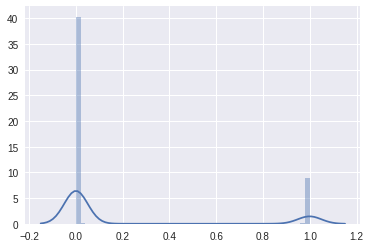

In [31]:
sns.distplot(all_pred)

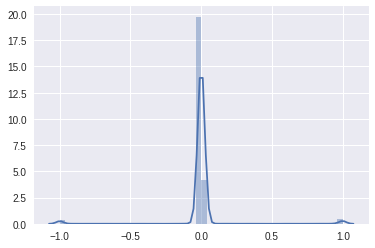

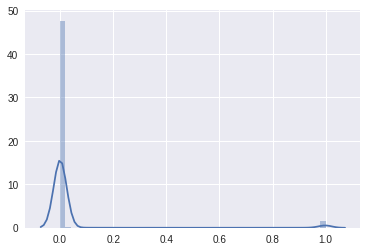

In [18]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(error)
plt.show()
sns.distplot(np.abs(error))

In [34]:
print np.sum(np.abs(error) > 0.01) 1354
print np.sum(np.abs(error) > 0.99) 864
print 861.0/test_total

1354
861
0.0313626926019


In [ ]:
np.abs(error) > 0.99

In [35]:
test_total

27453

In [73]:
generate_predictions_csv(model, 'out1.csv')

In [ ]:
train('model_post1.1_3_32_lr_001.tar', epochs=10, **torch.load('model_post1_3_32_lr_001.tar'))

---Epoch 8---


In [80]:
torch.load('model_3_32_lr_001.tar')

{'criterion': CrossEntropyLoss (
 ), 'cur_epoch': 4, 'model': Model1 (
   (drug_embedding): Embedding(2870, 30)
   (dx_embedding): Embedding(12, 5)
   (gru1): GRU(39, 32, num_layers=3, batch_first=True)
   (dense1): Linear (32 -> 2)
   (softmax): Softmax ()
 ), 'optimizer': <torch.optim.adam.Adam at 0x7f23016a2350>, 'test_aucs': [0.9497745120551091,
  0.95737772101378837,
  0.96352282510260245,
  0.97322535701846047], 'test_losses': [0.35393751389666983,
  0.35761409787089349,
  0.35281944691292533,
  0.34829183176775053], 'train_losses': [0.37126914617345386,
  0.33828777079089706,
  0.33836713117440947,
  0.39558140579214862]}

In [12]:
def validate_all(model):
    all_true = np.zeros((test_total, 2))
    all_pred = np.zeros((test_total, 2))
    total_test_loss = 0
    i = 0
    for b in tqdm_notebook(test_pt_by_len):
        hidden, inp, target = prepare_input(np.array(test_pt_by_len[b]))
        target2 = target[:]
        hidden, inp, posts, drugs, dxs, target = torchify_batch(hidden, inp, target)
        out = model(hidden.cuda(), inp.cuda(), posts.cuda(), drugs.cuda(), dxs.cuda())

        target.cuda()

        loss = criterion(out, target.cuda())
        out_np = out.data.cpu().numpy()
        for j in xrange(target2.shape[0]):
            all_true[i, int(target2[j])] = 1
            all_pred[i] = out_np[j]
            i += 1
        total_test_loss += loss.data.cpu().numpy()[0]
    test_loss = total_test_loss/288
    test_auc = roc_auc_score(all_true, all_pred)
    return test_loss, test_auc

validate_all(model)

Widget Javascript not detected.  It may not be installed or enabled properly.


(0.35821641802842302, 0.94314307203172887)

In [7]:
test_total

27453